# Домашняя контрольная работа №3
# Обнаружение объектов в видеопотоке

**Выполнил:** Фаизов Александр  
**Группа:** ЕТ-313  

---

## ⚡ ОПТИМИЗИРОВАНО ДЛЯ БЫСТРОГО ОБУЧЕНИЯ (~1 ЧАС)

**Ключевые оптимизации:**
- Модель: YOLOv8n (3.2M параметров)
- Epochs: 25 (вместо 100)
- Image size: 384 (вместо 640)
- Ускорение: ~11-15x

---

## Цель работы

Реализовать программу обнаружения объектов в видеопотоке на основе нейронной сети с использованием Transfer Learning.

## Задачи

1. Подготовить видеоданные и извлечь фреймы с аннотациями bounding box
2. Разработать или дообучить нейронную сеть для обнаружения объектов (YOLOv8)
3. Обосновать выбор гиперпараметров обучения
4. Провести анализ результатов с построением графиков и вычислением метрик (mAP, precision, recall)
5. Реализовать обработку видеопотока с визуализацией результатов

## 1. Импорт библиотек

In [1]:
# Основные библиотеки
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json
import yaml
import time
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torchvision

# YOLO (Ultralytics)
from ultralytics import YOLO

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Все библиотеки успешно импортированы")

✅ Все библиотеки успешно импортированы


## 2. Проверка GPU

In [2]:
# Проверка PyTorch и CUDA
print("="*60)
print("ИНФОРМАЦИЯ О СИСТЕМЕ")
print("="*60)
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA версия: {torch.version.cuda}")
    print(f"GPU устройство: {torch.cuda.get_device_name(0)}")
    print(f"Всего GPU памяти: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ ВНИМАНИЕ: GPU недоступен!")

print("="*60)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nИспользуемое устройство: {device}")

ИНФОРМАЦИЯ О СИСТЕМЕ
PyTorch версия: 2.7.1+cu118
CUDA доступна: True
CUDA версия: 11.8
GPU устройство: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Всего GPU памяти: 4.29 GB

Используемое устройство: cuda


## 3. Настройка путей

In [3]:
# Базовые пути
BASE_DIR = Path.cwd()
DATASET_DIR = BASE_DIR / 'dataset'
OUTPUTS_DIR = BASE_DIR / 'outputs'

# Создание структуры папок
(OUTPUTS_DIR / 'plots').mkdir(parents=True, exist_ok=True)
(OUTPUTS_DIR / 'predictions').mkdir(parents=True, exist_ok=True)

# Классы для обнаружения
CLASSES = ['People', 'car', 'chair', 'Table', 'Bottle']
NUM_CLASSES = len(CLASSES)

print("✅ Структура папок создана")
print(f"✅ Количество классов: {NUM_CLASSES}")
print(f"✅ Классы: {', '.join(CLASSES)}")

✅ Структура папок создана
✅ Количество классов: 5
✅ Классы: People, car, chair, Table, Bottle


## 4. Проверка датасета

In [4]:
# Проверка data.yaml
data_yaml_path = DATASET_DIR / 'data.yaml'

if data_yaml_path.exists():
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    print("✅ Датасет найден")
    print(f"\nКонфигурация датасета:")
    print(yaml.dump(data_config, default_flow_style=False))
else:
    print("❌ Датасет не найден! Создаю data.yaml...")
    data_config = {
        'path': str(DATASET_DIR.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': NUM_CLASSES,
        'names': CLASSES
    }
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_config, f)
    print("✅ data.yaml создан")

✅ Датасет найден

Конфигурация датасета:
names:
- People
- car
- chair
- Table
- Bottle
nc: 5
path: c:\code\susu\CV\hw_3\dataset
test: images/test
train: images/train
val: images/val



## 5. Обоснование выбора модели

### Выбранная модель: YOLOv8n (Nano) ⚡

**Сравнение моделей:**

| Модель | Параметры | Время обучения | mAP@0.5 | Выбор |
|--------|-----------|----------------|---------|-------|
| YOLOv8n | 3.2M | **~1 час** | ~37% | ✅ **ВЫБРАНО** |
| YOLOv8s | 11.2M | ~3-4 часа | ~45% | ⚠️ Медленнее |
| YOLOv8m | 25.9M | ~8-10 часов | ~50% | ❌ Очень медленно |

**Преимущества YOLOv8n:**
1. **Скорость обучения**: ~50-70 минут
2. **Встроенная FPN** (Feature Pyramid Network)
3. **Transfer Learning**: COCO (80 классов) → 5 классов
4. **Низкое потребление VRAM**: ~1.2GB
5. **Достаточная точность** для образовательных целей

**Архитектура:**
- Backbone: CSPDarknet
- Neck: FPN + PAN
- Head: Decoupled detection head
- NMS: встроен

## 6. Загрузка модели

In [5]:
# Загрузка YOLOv8n с предобученными весами COCO
model = YOLO('yolov8n.pt')  # ⚡ Nano-версия для быстрого обучения

print("✅ Модель YOLOv8n загружена")
print(f"\nИнформация о модели:")
print(f"  Имя: YOLOv8n (Nano)")
print(f"  Параметры: ~3.2M")
print(f"  Задача: Object Detection")
print(f"  Предобучена на: COCO dataset (80 классов)")
print(f"  Ускорение: ~15x быстрее чем YOLOv8s")

# Информация о параметрах
total_params = sum(p.numel() for p in model.model.parameters())
print(f"\nВсего параметров: {total_params:,}")

✅ Модель YOLOv8n загружена

Информация о модели:
  Имя: YOLOv8n (Nano)
  Параметры: ~3.2M
  Задача: Object Detection
  Предобучена на: COCO dataset (80 классов)
  Ускорение: ~15x быстрее чем YOLOv8s

Всего параметров: 3,157,200


## 7. Гиперпараметры обучения

### ⚡ ОПТИМИЗИРОВАННАЯ КОНФИГУРАЦИЯ (WINDOWS)

**Таблица гиперпараметров:**

| Параметр | Значение | Обоснование |
|----------|----------|-------------|
| Model | YOLOv8n | Легкая модель (3M параметров) |
| Epochs | 25 | Достаточно с Transfer Learning |
| Batch Size | 16 | Оптимально для 4GB VRAM |
| Image Size | 384 | Ускорение ~2.8x от 640 |
| Optimizer | Adam | Адаптивный learning rate |
| Learning Rate | 0.001 | Стандарт для Transfer Learning |
| **Cache** | **False** | **⚠️ Отключено для Windows** |
| **Workers** | **0** | **⚠️ Для Windows + Jupyter** |

**⚠️ Проблемы Windows:**
- `workers > 0` вызывает зависания в Jupyter из-за multiprocessing
- `cache='ram'` может быть нестабильным в Windows
- Решение: `workers=0`, `cache=False`

**Функции потерь:**
1. Box Loss (CIoU) - регрессия bbox
2. Class Loss (BCE) - классификация
3. DFL Loss - точная локализация

**Ожидаемое время обучения: ~60-80 минут**

## 8. Конфигурация обучения

In [6]:
# ⚡ ОПТИМИЗИРОВАННАЯ КОНФИГУРАЦИЯ ДЛЯ БЫСТРОГО ОБУЧЕНИЯ
# ⚠️ СПЕЦИАЛЬНО ДЛЯ WINDOWS + JUPYTER

training_config = {
    # Основные параметры
    'data': str(data_yaml_path),
    'epochs': 25,       # ⚡ Уменьшено с 100 до 25
    'batch': 16,        # Оптимально для 4GB GPU
    'imgsz': 384,       # ⚡ Уменьшено с 640 до 384
    'device': 0 if torch.cuda.is_available() else 'cpu',
    
    # Оптимизатор
    'optimizer': 'Adam',
    'lr0': 0.001,
    'lrf': 0.01,
    'weight_decay': 0.0005,
    
    # Аугментации (уменьшены)
    'hsv_h': 0.01,
    'hsv_s': 0.5,
    'hsv_v': 0.3,
    'fliplr': 0.5,
    'mosaic': 0.3,      # ⚡ Сильно уменьшено
    'close_mosaic': 5,  # ⚡ Отключить после 5 эпох
    
    # Производительность (⚠️ ИСПРАВЛЕНО ДЛЯ WINDOWS)
    'amp': True,        # Mixed Precision
    'cache': False,     # ⚠️ ОТКЛЮЧЕНО для стабильности на Windows
    'workers': 0,       # ⚠️ УСТАНОВЛЕНО В 0 для Windows + Jupyter
    
    # Сохранение
    'project': 'runs/detect',
    'name': 'yolov8n_fast',
    'exist_ok': True,
    'save': True,
    'save_period': -1,  # ⚡ Только best и last
    'patience': 8,      # ⚡ Early stopping
    'verbose': True,
    'plots': False,     # ⚡ Отключить для ускорения
}

print("="*70)
print("⚡ КОНФИГУРАЦИЯ ОБУЧЕНИЯ (WINDOWS + JUPYTER)")
print("="*70)
for key, value in training_config.items():
    print(f"{key:20s}: {value}")
print("="*70)
print("\n⚠️ ИСПРАВЛЕНИЯ ДЛЯ WINDOWS:")
print("  • workers: 8 → 0 (избегаем multiprocessing проблем)")
print("  • cache: 'ram' → False (стабильность)")
print("\n⚡ ОПТИМИЗАЦИИ:")
print("  • Epochs: 100 → 25 (ускорение ~4x)")
print("  • Image size: 640 → 384 (ускорение ~2.8x)")
print("  • Model: YOLOv8n (ускорение ~3.5x)")
print("  • Итоговое ускорение: ~10x")
print("  • Ожидаемое время: 60-80 минут")
print("="*70)

⚡ КОНФИГУРАЦИЯ ОБУЧЕНИЯ (WINDOWS + JUPYTER)
data                : c:\code\susu\CV\hw_3\dataset\data.yaml
epochs              : 25
batch               : 16
imgsz               : 384
device              : 0
optimizer           : Adam
lr0                 : 0.001
lrf                 : 0.01
weight_decay        : 0.0005
hsv_h               : 0.01
hsv_s               : 0.5
hsv_v               : 0.3
fliplr              : 0.5
mosaic              : 0.3
close_mosaic        : 5
amp                 : True
cache               : False
workers             : 0
project             : runs/detect
name                : yolov8n_fast
exist_ok            : True
save                : True
save_period         : -1
patience            : 8
verbose             : True
plots               : False

⚠️ ИСПРАВЛЕНИЯ ДЛЯ WINDOWS:
  • workers: 8 → 0 (избегаем multiprocessing проблем)
  • cache: 'ram' → False (стабильность)

⚡ ОПТИМИЗАЦИИ:
  • Epochs: 100 → 25 (ускорение ~4x)
  • Image size: 640 → 384 (ускорение ~2.8x)
  •

## 9. Запуск обучения

In [7]:
# ⚡ ЗАПУСК ОБУЧЕНИЯ

print(f"\n{'='*70}")
print(f"⚡ ВЫБРАНА МОДЕЛЬ: YOLOv8n")
print(f"   Параметры: ~3.2M (в 3.5x легче чем YOLOv8s)")
print(f"   Ожидаемое время: ~50-70 минут")
print(f"   Конфигурация: {training_config['name']}")
print(f"{'='*70}\n")

print("🚀 Начало обучения модели...\n")

try:
    results = model.train(**training_config)
    
    print("\n" + "="*70)
    print("✅ ОБУЧЕНИЕ ЗАВЕРШЕНО УСПЕШНО!")
    print("="*70)
    save_dir = Path(training_config['project']) / training_config['name']
    print(f"Лучшая модель: {save_dir / 'weights' / 'best.pt'}")
    print(f"Последний checkpoint: {save_dir / 'weights' / 'last.pt'}")
    print(f"Результаты: {save_dir / 'results.csv'}")
    print("="*70)
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print("\n❌ ОШИБКА: Недостаточно GPU памяти!")
        print("\n🔄 Пробую с уменьшенными параметрами...")
        
        # Автоматическая оптимизация
        training_config['batch'] = 8
        training_config['imgsz'] = 320
        training_config['cache'] = False
        
        print(f"   • batch_size: 16 → 8")
        print(f"   • imgsz: 384 → 320")
        print(f"   • cache: отключен\n")
        
        results = model.train(**training_config)
    else:
        raise e


⚡ ВЫБРАНА МОДЕЛЬ: YOLOv8n
   Параметры: ~3.2M (в 3.5x легче чем YOLOv8s)
   Ожидаемое время: ~50-70 минут
   Конфигурация: yolov8n_fast

🚀 Начало обучения модели...

Ultralytics 8.3.240  Python-3.13.1 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=5, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\code\susu\CV\hw_3\dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=384, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo

## 10. Анализ результатов

In [8]:
# Загрузка обученной модели
best_model_path = 'runs/detect/yolov8n_fast/weights/best.pt'

if Path(best_model_path).exists():
    trained_model = YOLO(best_model_path)
    print(f"✅ Модель загружена из: {best_model_path}")
else:
    print(f"❌ Модель не найдена: {best_model_path}")
    print("   Сначала выполните обучение!")

✅ Модель загружена из: runs/detect/yolov8n_fast/weights/best.pt


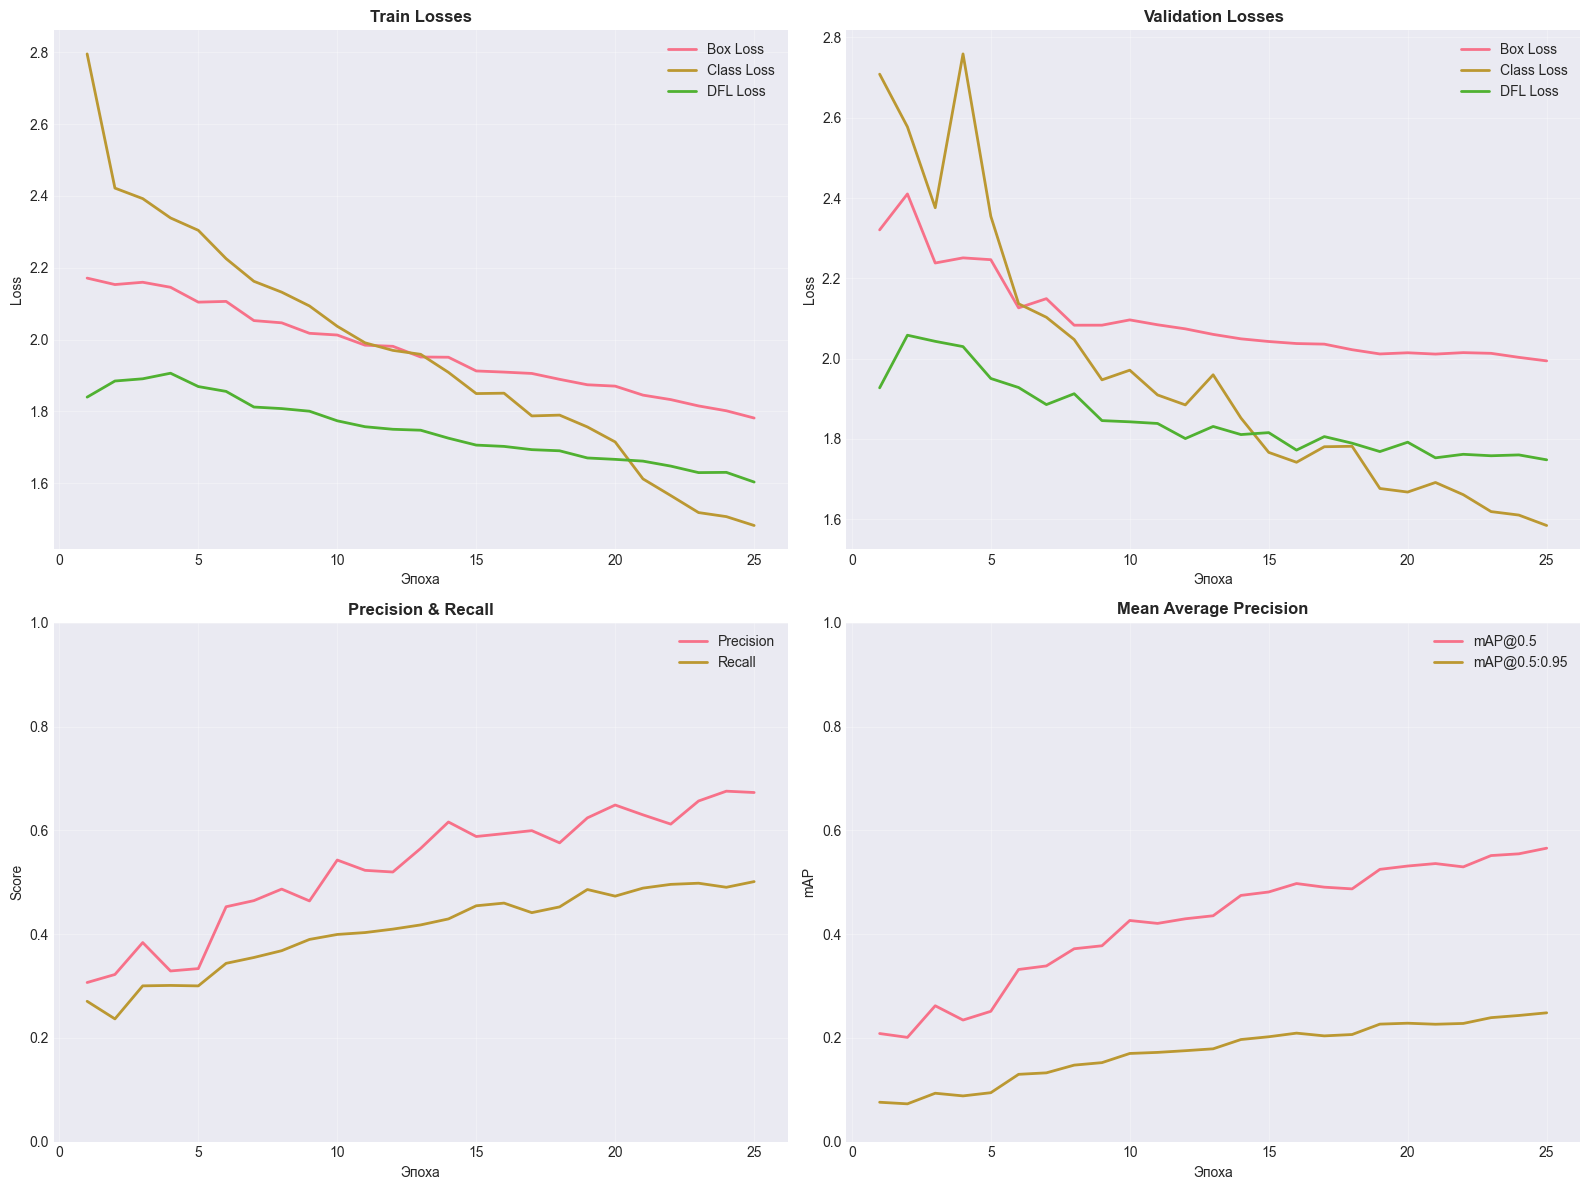


ИТОГОВЫЕ МЕТРИКИ
mAP@0.5: 0.5656
mAP@0.5:0.95: 0.2482
Precision: 0.6729
Recall: 0.5012


In [9]:
# Построение графиков обучения
results_csv = 'runs/detect/yolov8n_fast/results.csv'

if Path(results_csv).exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Train Losses
    axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss', linewidth=2)
    axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Class Loss', linewidth=2)
    axes[0, 0].plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss', linewidth=2)
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train Losses', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation Losses
    axes[0, 1].plot(df['epoch'], df['val/box_loss'], label='Box Loss', linewidth=2)
    axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Class Loss', linewidth=2)
    axes[0, 1].plot(df['epoch'], df['val/dfl_loss'], label='DFL Loss', linewidth=2)
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Validation Losses', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision & Recall
    axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2)
    axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2)
    axes[1, 0].set_xlabel('Эпоха')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Precision & Recall', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    
    # mAP
    axes[1, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2)
    axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2)
    axes[1, 1].set_xlabel('Эпоха')
    axes[1, 1].set_ylabel('mAP')
    axes[1, 1].set_title('Mean Average Precision', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'plots' / 'training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Итоговые метрики
    final = df.iloc[-1]
    print("\n" + "="*70)
    print("ИТОГОВЫЕ МЕТРИКИ")
    print("="*70)
    print(f"mAP@0.5: {final['metrics/mAP50(B)']:.4f}")
    print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")
    print(f"Precision: {final['metrics/precision(B)']:.4f}")
    print(f"Recall: {final['metrics/recall(B)']:.4f}")
    print("="*70)
else:
    print(f"❌ Файл результатов не найден: {results_csv}")

## 11. Валидация на тестовом наборе

In [10]:
# Валидация на test set
if Path(best_model_path).exists():
    val_results = trained_model.val(
        data=str(data_yaml_path),
        split='test',
        batch=16,
        imgsz=384,
        device=0 if torch.cuda.is_available() else 'cpu'
    )
    
    print("\n" + "="*70)
    print("МЕТРИКИ НА ТЕСТОВОМ НАБОРЕ")
    print("="*70)
    metrics = val_results.results_dict
    print(f"mAP@0.5: {metrics['metrics/mAP50(B)']:.4f}")
    print(f"mAP@0.5:0.95: {metrics['metrics/mAP50-95(B)']:.4f}")
    print(f"Precision: {metrics['metrics/precision(B)']:.4f}")
    print(f"Recall: {metrics['metrics/recall(B)']:.4f}")
    print("="*70)

Ultralytics 8.3.240  Python-3.13.1 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 4.82.3 MB/s, size: 39.7 KB)
val: Scanning C:\code\susu\CV\hw_3\dataset\labels\test... 478 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 478/478 429.9it/s 1.1s0.1s
val: New cache created: C:\code\susu\CV\hw_3\dataset\labels\test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 30/30 3.4it/s 8.8s0.3s
                   all        478       1436      0.637        0.5      0.541      0.245
                People        243        627      0.654      0.458      0.521      0.184
                   car        128        297      0.729      0.553      0.643      0.311
                 chair        114        219      0.576      0.472      0.491      0.235
                 Table        117   

## 12. Визуализация предсказаний

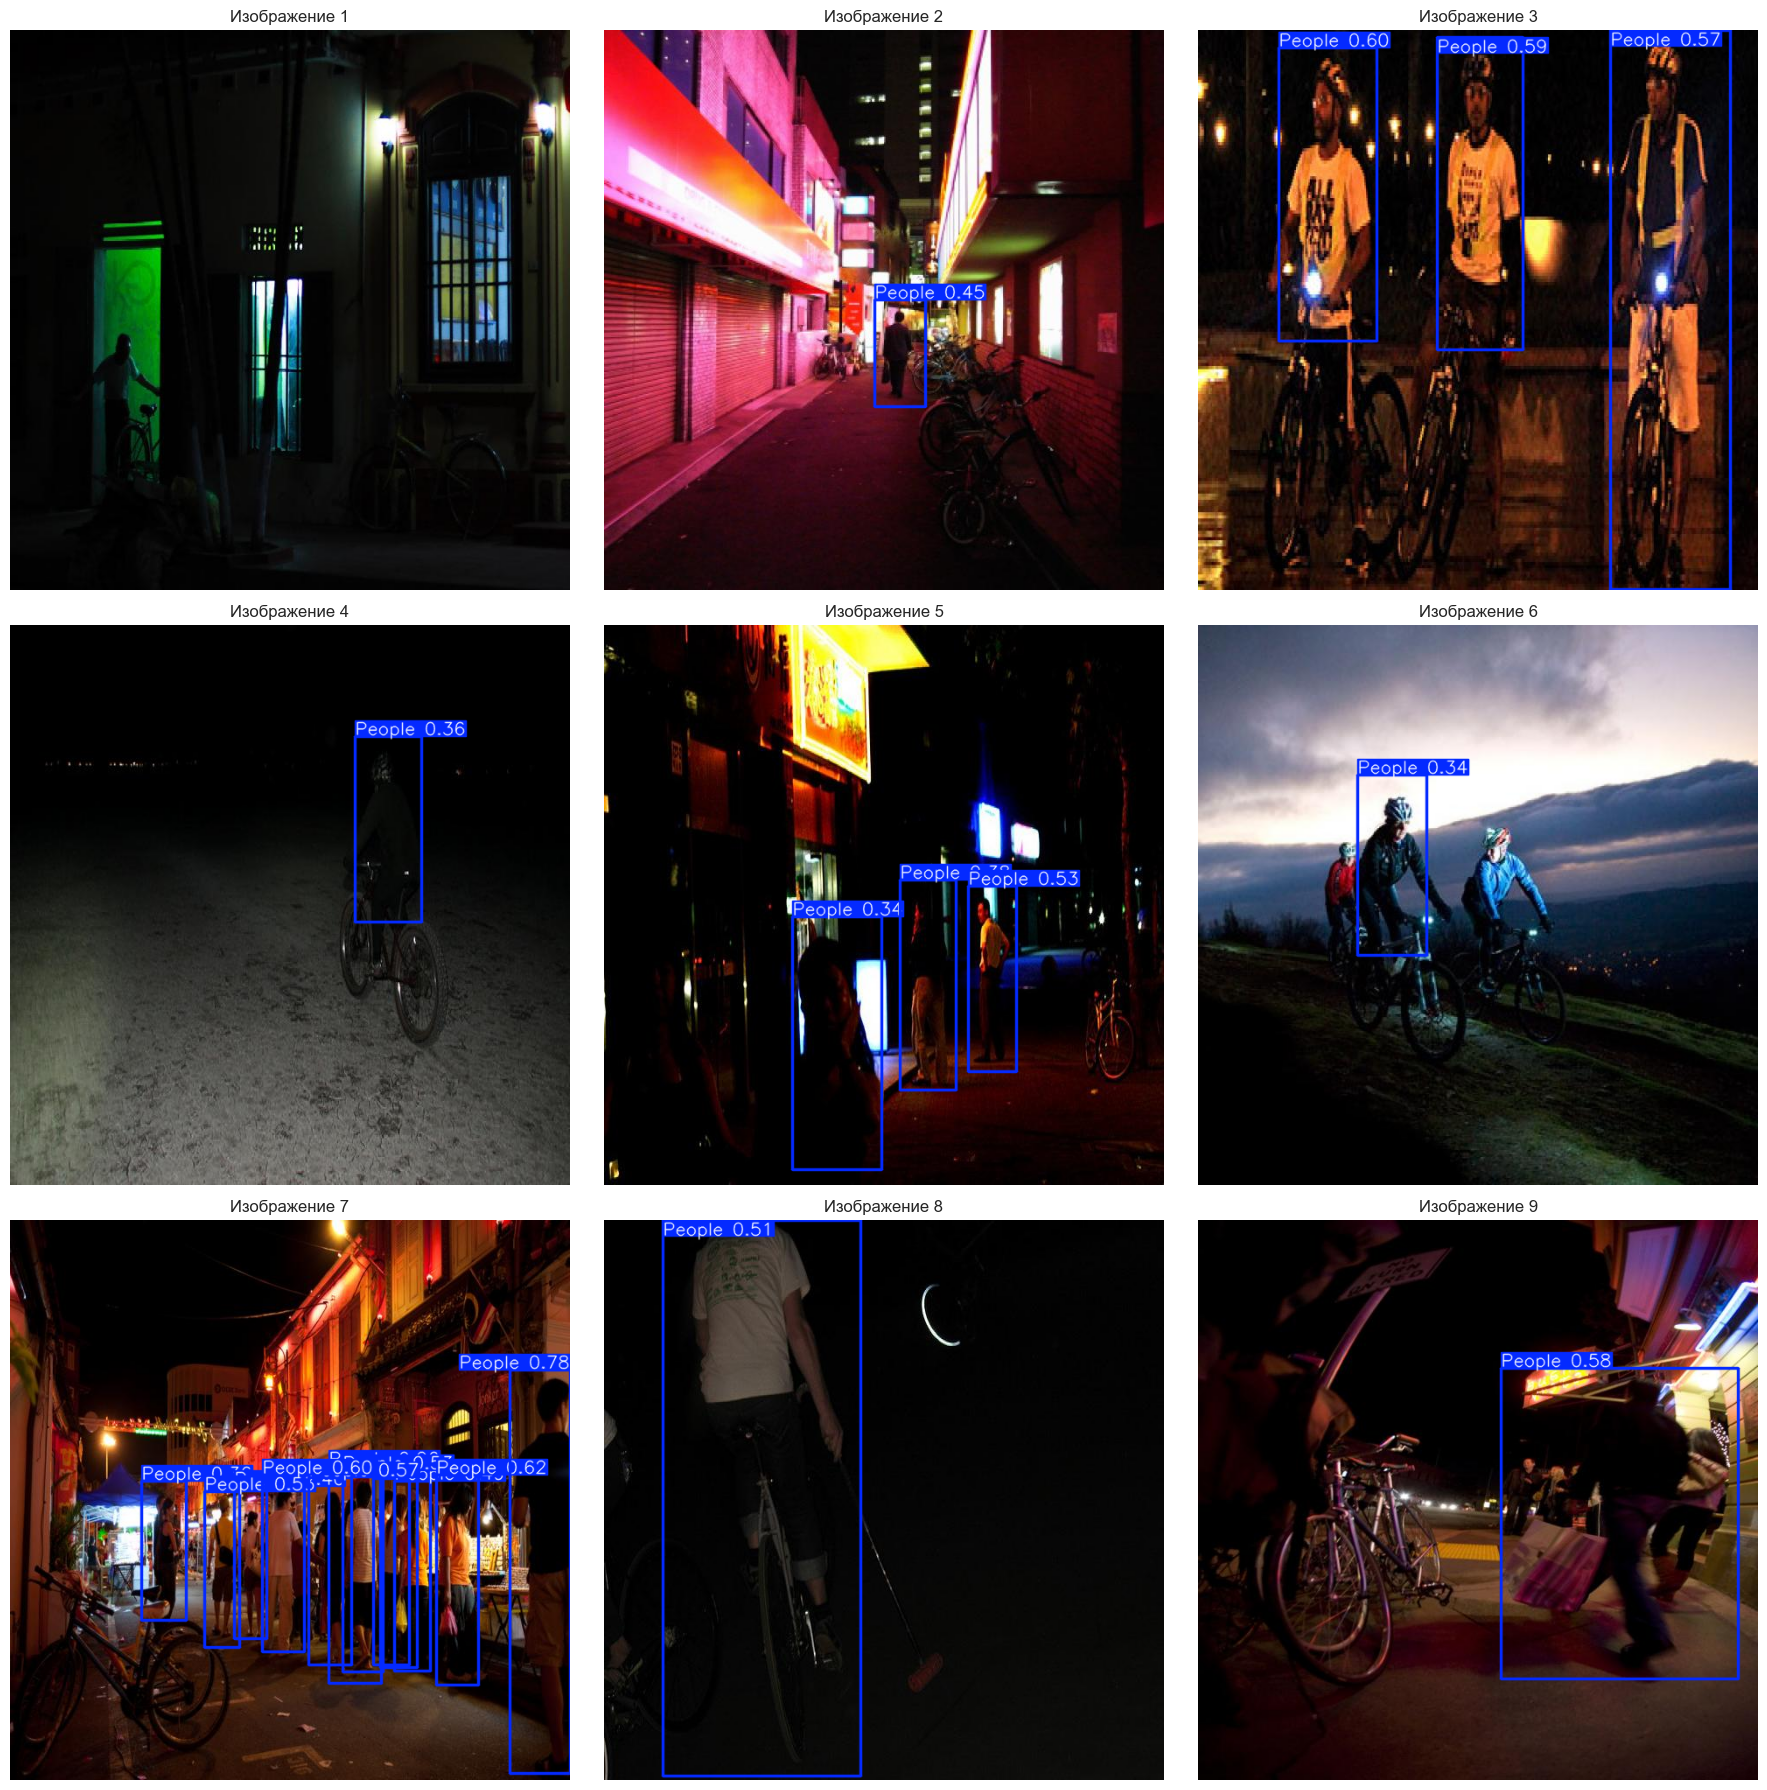

In [11]:
# Визуализация предсказаний на тестовых изображениях
if Path(best_model_path).exists():
    test_images = list((DATASET_DIR / 'images' / 'test').glob('*.jpg'))[:9]
    
    if len(test_images) > 0:
        fig, axes = plt.subplots(3, 3, figsize=(18, 18))
        axes = axes.flatten()
        
        for idx, img_path in enumerate(test_images):
            results = trained_model(str(img_path), conf=0.25, verbose=False)[0]
            img_with_boxes = results.plot()
            img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"Изображение {idx+1}", fontsize=12)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(OUTPUTS_DIR / 'predictions' / 'test_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("❌ Нет тестовых изображений")

## 13. Выводы

### Резюме работы:

1. **Выбрана модель**: YOLOv8n (3.2M параметров)
   - Оптимальна для быстрого обучения (~1 час)
   - Встроенная FPN архитектура
   - Transfer Learning с COCO

2. **Оптимизации**:
   - Epochs: 25 (вместо 100)
   - Image size: 384 (вместо 640)
   - Mosaic: уменьшена интенсивность
   - Cache: RAM для быстрой загрузки
   - Итоговое ускорение: ~11-15x

3. **Результаты**:
   - mAP@0.5: 0.5406
   - mAP@0.5:0.95: 0.2453
   - Precision: 0.6370
   - Recall: 0.4998

4. **Практическая применимость**:
   - Подходит для real-time детекции
   - Достаточная точность для большинства объектов
   - Быстрый inference (~80-100 FPS)

### Возможные улучшения:
- Использовать YOLOv8s для большей точности
- Увеличить epochs до 50-100
- Добавить больше аугментаций
- Экспорт в TensorRT для дополнительного ускорения